In [1]:
Seed = 7

In [104]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
np.random.seed(Seed)
tf.random.set_seed(Seed)
Seed += 1

In [105]:
#inporting all the data
remote_sensing_reflectance = pd.read_csv("all_habs_rrs_only.csv").fillna(0)
shatonela_diatom = pd.read_csv("all_concatinated_data.csv", low_memory=False)
karenia = pd.read_csv("all_karenia_data.csv", low_memory=False)  # import karenia data from the server here

In [106]:
# combining shatonela diatom and karenia data together
akashivo_data = pd.concat([shatonela_diatom, karenia], axis=0)
akashivo_data.to_csv("akashivo_data.csv", encoding='utf-8-sig')
akashivo_data.rename(columns ={'緯度':'lat', '経度':'lon', '採取日':'date', 'シャットネラ属':'shatonela', '珪藻類合計':'diatom', 'カレニア　ミキモトイ':'karenia'} , inplace = True)
akashivo_data.drop(['Unnamed: 4', '赤潮細胞数の単位', '採水層', '地点名'], inplace=True, axis=1)

In [107]:
# connect the two dataframes with lat logn and date
merged_data = pd.merge(akashivo_data, remote_sensing_reflectance, on=["lat", "lon", "date"], how = 'left').fillna(0)
merged_data.drop(['Unnamed: 0.1', 'Unnamed: 0', 'identifier', 'file_status', 'download_url', 'preview_url', 'resolution'], inplace=True, axis=1)
print(merged_data['karenia'])

0             0.0
1             0.0
2             0.0
3             0.0
4             0.0
           ...   
253649     2040.0
253650    80500.0
253651    80500.0
253652    26750.0
253653    26750.0
Name: karenia, Length: 253654, dtype: float64


In [108]:
# filder all the duplicates
columns_to_check = ['shatonela', 'diatom', 'karenia', 'Rrs_380', 'Rrs_412', 'Rrs_443', 'Rrs_490', 'Rrs_530', 'Rrs_565', 'Rrs_670']
filtered_df = merged_data[~merged_data.duplicated(subset=columns_to_check, keep='first')]
filtered_df = filtered_df[~(filtered_df[['Rrs_380', 'Rrs_412', 'Rrs_443', 'Rrs_490', 'Rrs_530', 'Rrs_565', 'Rrs_670']] <= 0).any(axis=1)]
filtered_df.to_csv("data.csv", encoding="utf-8-sig")

In [109]:
# modifing the data to the correct form
output_colums = filtered_df[['shatonela', 'diatom', 'karenia']]
input_colums = filtered_df[['Rrs_380', 'Rrs_412', 'Rrs_443', 'Rrs_490', 'Rrs_530', 'Rrs_565', 'Rrs_670']]
print(len(input_colums))

7355


In [110]:
# putting Rrs thrue a log`
# scaler = MinMaxScaler()
# x = scaler.fit_transform(input_colums)
x = np.log(input_colums)

x.shape

(7355, 7)

In [111]:
# converts all the values in to 1es and 0es
y = (output_colums > 0).any(axis=1)
y = np.array(y)

In [112]:
# randomaizing test and training data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=Seed)

In [113]:
partial_x_train, x_val, partial_y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=Seed)

In [114]:
def build_model():
    model = models.Sequential()

    # model.add(layers.Dense(128, activation="relu", input_shape = (7,)))
    model.add(layers.Reshape((1,7), input_shape = (7,)))

    model.add(layers.LSTM(64, activation="relu", return_sequences=True))
    model.add(layers.LSTM(128, activation="relu", return_sequences=True))

    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy'])
    
    return model

In [115]:
model = build_model()
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=100,
                    batch_size=500,
                    validation_data=(x_val, y_val))


ValueError: Input 0 of layer "lstm_10" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 64)

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

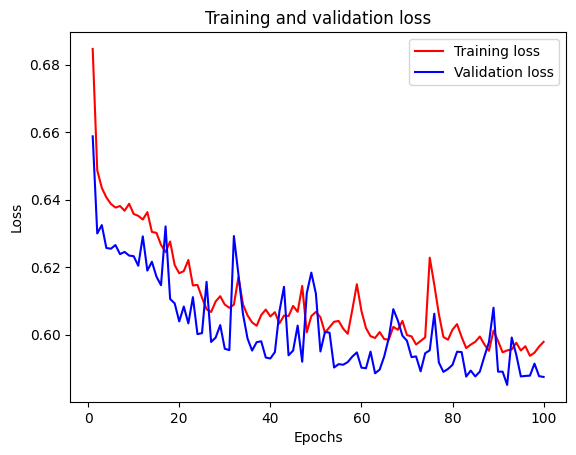

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

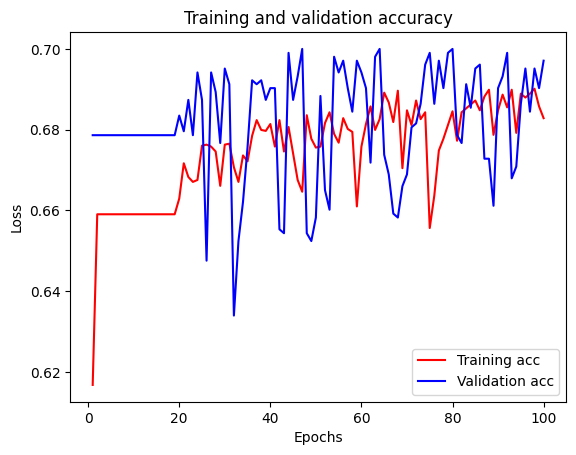

In [ ]:
plt.clf() 
acc_values = history_dict['accuracy'] 
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)

print(f"Accuracy: {accuracy * 100:.2f}%")

69/69 [==============================] - 0s 800us/step - loss: 0.5835 - accuracy: 0.6991
Accuracy: 69.91%
